In [170]:
import re
import json
import pandas as pd
import numpy as np
import google.cloud.bigquery as bq
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection
from sklearn import metrics
from sklearn import impute
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import compose
from sklearn import linear_model
from sklearn import ensemble
from sklearn import feature_extraction
from category_encoders import target_encoder
import matplotlib.pyplot as plt

### Ingest Data

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery data
SELECT
  *
FROM `curious-bot.homes.ad_details`
WHERE price_per_sq_m IS NOT NULL
  AND post_code IS NOT NULL

In [4]:
data.set_index('id', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7544 entries, 5071b23d-0c43-4021-b5a5-91c34b612038 to a7b43aee-e5bc-42e6-abe2-8ab317a66c60
Data columns (total 16 columns):
new_building      7544 non-null bool
promoted          7544 non-null bool
price             7544 non-null int64
area              7544 non-null int64
price_per_sq_m    7544 non-null int64
type              7544 non-null object
viewed            7544 non-null datetime64[ns, UTC]
address           7544 non-null object
post_code         7544 non-null object
street_num        7532 non-null object
street_name       7540 non-null object
postal_town       7544 non-null object
country           7544 non-null object
lat               7544 non-null float64
lng               7544 non-null float64
short_desc        7544 non-null object
dtypes: bool(2), datetime64[ns, UTC](1), float64(2), int64(3), object(8)
memory usage: 898.8+ KB


### Define Utils

In [271]:
def demo(dataset, feature_col):
    example = next(iter(dataset))[0]
    feature_layer = tf.keras.layers.DenseFeatures(feature_col)
    print(feature_layer(example).numpy())

def input_to_estimator(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    return ds.batch(batch_size)

def mean_absolute_prc_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def get_metrics(y_true, y_pred, model_name):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_prc_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return {'model': model_name, 'mae': mae, 'mape': mape, 'r2': r2}

### Hyperparameters

In [272]:
random_seed = 42
test_size = 0.3
batch_size = 300
n_area_bins = 5
min_points_per_post_code = 20

### Prepare Train And Test Datasets

In [273]:
X_cols = ['new_building', 'promoted', 'area', 'type', 'post_code']

X = data[X_cols]
y = data.price_per_sq_m

data_train, data_test = model_selection.train_test_split(data,
                                                         test_size=test_size,
                                                         random_state=random_seed)

X_train, X_test = data_train[X_cols], data_test[X_cols]
y_train, y_test = data_train.price_per_sq_m, data_test.price_per_sq_m

ds_train = input_to_estimator(X_train, y_train, batch_size)
ds_test = input_to_estimator(X_test, y_test, batch_size)

### Benchmark Median Price Per Square Meter

In [274]:
metrics_list = []
style_format = {'mae': '{:.0f}', 'mape': '{:.0%}', 'r2': '{:.0%}'}

In [275]:
y_pred = [y_train.median()] * len(y_test)
metrics_list.append(get_metrics(y_test, y_pred, 'benchmark_median_price'))

In [276]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,16670,26%,-0%


### Benchmark Median Price Per Square Meter Per Post Code

In [277]:
med_price_post_code = data_train.groupby('post_code').price_per_sq_m.median()
count_post_code = data_train.groupby('post_code').price_per_sq_m.count()

In [278]:
post_codes_above_min_points = count_post_code[count_post_code > min_points_per_post_code].index

In [279]:
med_price_post_code_sel = med_price_post_code.loc[post_codes_above_min_points]
med_price_post_code_sel.rename('post_code_median_price', inplace=True)

y_pred = data_test.merge(med_price_post_code_sel,
                         how='left',
                         left_on='post_code',
                         right_index=True).post_code_median_price

y_pred.fillna(y_train.median(), inplace=True)

In [280]:
metrics_list.append(get_metrics(y_test, y_pred, 'benchmark_median_price_per_post_code'))

In [281]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,16670,26%,-0%
benchmark_median_price_per_post_code,15182,24%,15%


### Linear Regression

In [282]:
cat_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_enc', target_encoder.TargetEncoder(handle_unknown='ignore'))
])

num_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('bucketize', preprocessing.KBinsDiscretizer(n_bins=n_area_bins))
])

preprocessor = compose.ColumnTransformer(transformers=[
    ('cat_transf', cat_transformer, ['post_code']),
    ('num_transf', num_transformer, ['area'])
])

linreg = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_reg', linear_model.LinearRegression())
])

In [283]:
linreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_transf',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='unknown',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                               

In [284]:
y_pred = linreg.predict(X_test)
metrics_list.append(get_metrics(y_test, y_pred, 'linear_regression'))

In [285]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,16670,26%,-0%
benchmark_median_price_per_post_code,15182,24%,15%
linear_regression,13638,20%,29%


### Gradient Boosting Regressor

In [286]:
boostreg = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_reg', ensemble.GradientBoostingRegressor())
])

In [287]:
boostreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat_transf',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='unknown',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                               

In [288]:
y_pred = boostreg.predict(X_test)
metrics_list.append(get_metrics(y_test, y_pred, 'gradient_boosting_regressor'))

In [289]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,16670,26%,-0%
benchmark_median_price_per_post_code,15182,24%,15%
linear_regression,13638,20%,29%
gradient_boosting_regressor,11120,16%,39%


### Deep Learning Model

In [290]:
area_bins = list(range(30, 180, 30))
all_post_codes = list(X_train.post_code.unique())

area = tf.feature_column.numeric_column('area')
area_bucket = tf.feature_column.bucketized_column(area, boundaries=area_bins)

promoted = tf.feature_column.numeric_column('promoted')

new_building = tf.feature_column.numeric_column('new_building')

real_est_type = tf.feature_column.categorical_column_with_vocabulary_list('type', ['apartment', 'semi_detached', 'terraced', 'detached'])
real_est_type_1_hot = tf.feature_column.indicator_column(real_est_type)


post_code = tf.feature_column.categorical_column_with_vocabulary_list('post_code', all_post_codes)
post_code_embedding = tf.feature_column.embedding_column(post_code, dimension=20)
post_code_hash = tf.feature_column.categorical_column_with_hash_bucket('post_code', 50)
post_code_hash_ind = tf.feature_column.indicator_column(post_code_hash)

real_est_type_x_area_bucket = tf.feature_column.crossed_column([real_est_type, area_bucket], hash_bucket_size=20)
real_est_type_x_area_bucket_1_hot = tf.feature_column.indicator_column(real_est_type_x_area_bucket)

post_code_embedding_x_area_bucket = tf.feature_column.crossed_column([post_code, area_bucket], hash_bucket_size=200)
post_code_embedding_x_area_bucket_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_area_bucket)

post_code_embedding_x_real_est_type = tf.feature_column.crossed_column([post_code, real_est_type], hash_bucket_size=100)
post_code_embedding_x_real_est_type_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_real_est_type)

In [291]:
features = [area_bucket, promoted, new_building,
            real_est_type_1_hot, post_code_embedding,
            real_est_type_x_area_bucket_1_hot,
            post_code_embedding_x_area_bucket_1_hot,
            post_code_embedding_x_real_est_type_1_hot]

feature_layer = tf.keras.layers.DenseFeatures(features)

In [292]:
%%time

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=100,
                 verbose=0)

CPU times: user 2min 14s, sys: 11.4 s, total: 2min 26s
Wall time: 24.5 s


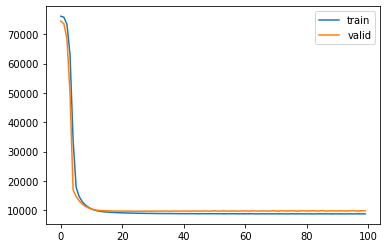

In [293]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [294]:
y_pred = model.predict(ds_test)

metrics_list.append(get_metrics(y_test, y_pred[:, 0], 'wide_and_deep_model'))

In [295]:
pd.DataFrame(metrics_list).set_index('model').style.format(style_format)

,mae,mape,r2
model,,,
benchmark_median_price,16670,26%,-0%
benchmark_median_price_per_post_code,15182,24%,15%
linear_regression,13638,20%,29%
gradient_boosting_regressor,11120,16%,39%
wide_and_deep_model,9739,14%,57%


### Text Model

In [296]:
stop_words = ['av', 'bak', 'blant', 'etter', 'for', 'fra',
              'gjennom', 'hos', 'i', 'ifølge', 'innen',
              'innenfor', 'med', 'mellom', 'mot', 'om',
              'omkring', 'ovenfor', 'på', 'rundt', 'til',
              'under', 'på grunn av', 'i henhold til',
              'ved hjelp av', 'og', 'over', 'pa', 'etg',
              'inkl', 'ingen', 'kvm']

In [297]:
count_vect = feature_extraction.text.CountVectorizer(strip_accents='unicode',
                                                     stop_words=stop_words,
                                                     max_features=400,
                                                     min_df=0.05,
                                                     max_df=0.9
                                                    )

In [304]:
count_vect.fit(data_train.short_desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=400, min_df=0.05,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['av', 'bak', 'blant', 'etter', 'for', 'fra',
                            'gjennom', 'hos', 'i', 'ifølge', 'innen',
                            'innenfor', 'med', 'mellom', 'mot', 'om', 'omkring',
                            'ovenfor', 'på', 'rundt', 'til', 'under',
                            'på grunn av', 'i henhold til', 'ved hjelp av',
                            'og', 'over', 'pa', 'etg', 'inkl', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [310]:
vocab_size = len(count_vect.vocabulary_)

In [338]:
text_train = count_vect.transform(data_train.short_desc)
text_test = count_vect.transform(data_test.short_desc)

In [339]:
text_train

<5280x44 sparse matrix of type '<class 'numpy.int64'>'
	with 28081 stored elements in Compressed Sparse Row format>

In [350]:
text_input = tf.keras.layers.Input(shape=(vocab_size, ), dtype='int32', name='short_description')
embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=32, input_length=vocab_size)(text_input)
dense_text = tf.keras.layers.Dense(16, activation='relu')(embedding)
dense_text = tf.keras.layers.Dense(8, activation='relu')(dense_text)
text_output = tf.keras.layers.Dense(1)(dense_text)

In [351]:
text_model = tf.keras.Model(inputs=text_input, outputs=text_output)
text_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [352]:
%%time
hist = text_model.fit(text_train.toarray(), y_train,
                      validation_data=(text_test.toarray(), y_test),
                      epochs=200, verbose=0, batch_size=batch_size)

CPU times: user 37.1 s, sys: 8.2 s, total: 45.3 s
Wall time: 14.6 s


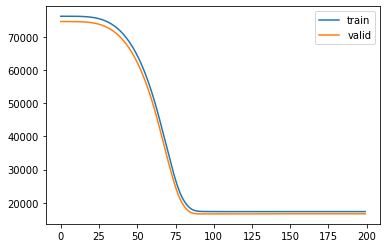

In [353]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()